In [7]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.tri as tri
from scipy import stats
from scipy.special import gamma as gamma_fun
from scipy import integrate
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import SEQUENCE_ECOLOGY
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.viz import plot_dirichlet_samples, plot_confusion_matrix
from deep_bayes.diagnostics import accuracy

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
tf.enable_eager_execution()

In [10]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [ ]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [5]:
def model1_params_prior(**args):
    """
    Samples from the prior of the Holling Type II model theta = (alpha, mu, gamma, g, h, sigma0, sigma1, init0, init1)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(low=0.0001, high=1.0), # alpha
        np.random.uniform(low=0.0001, high=1.0), # mu
        np.random.uniform(low=0.5, high=1.0),    # gamma
        np.random.uniform(low=0.01, high=0.1),   # g
        np.random.uniform(low=0.01, high=0.1),   # h
        np.random.uniform(low=0.0001, high=0.5), # sigma0
        np.random.uniform(low=0.0001, high=0.5), # sigma1
        np.random.uniform(low=0.0001, high=50),  # init0
        np.random.uniform(low=0.0001, high=50),  # init1
    ])
    return theta


def model2_params_prior(**args):
    """
    Samples from the prior of the Beddington-DeAngelis model theta = (alpha, mu, gamma, g, h, c, sigma0, sigma1, init0, init1)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(low=0.0001, high=1.0), # alpha
        np.random.uniform(low=0.0001, high=1.0), # mu
        np.random.uniform(low=0.5, high=1.0),    # gamma
        np.random.uniform(low=0.01, high=0.1),   # g
        np.random.uniform(low=0.01, high=0.1),   # h
        np.random.uniform(low=0.0001, high=0.01),# c
        np.random.uniform(low=0.0001, high=0.5), # sigma0
        np.random.uniform(low=0.0001, high=0.5), # sigma1
        np.random.uniform(low=0.0001, high=50),  # init0
        np.random.uniform(low=0.0001, high=50),  # init1
    ])
    return theta


def model3_params_prior(**args):
    """
    Samples from the prior of the Crowley-Martin model theta = (alpha, mu, gamma, g, h, c, sigma0, sigma1, init0, init1)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(low=0.0001, high=1.0), # alpha
        np.random.uniform(low=0.0001, high=1.0), # mu
        np.random.uniform(low=0.5, high=1.0),    # gamma
        np.random.uniform(low=0.01, high=0.1),   # g
        np.random.uniform(low=0.01, high=0.1),   # h
        np.random.uniform(low=0.0001, high=0.01),# c
        np.random.uniform(low=0.0001, high=0.5), # sigma0
        np.random.uniform(low=0.0001, high=0.5), # sigma1
        np.random.uniform(low=0.0001, high=50),  # init0
        np.random.uniform(low=0.0001, high=50),  # init1
    ])
    return theta

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|\boldsymbol{\theta},\boldsymbol{m}).$

In [26]:
def forward_model1(params, n_obs, **args):
    # params: [alpha,mu,gamma,g,h,sigma0,sigma1,init0,init1]
    # alpha: preys growth rate
    # mu: predators shrinkage rate
    # gamma: predators growth rate
    # g: attack rate
    # h: handling time
    # sigma0: preys distribution error term
    # sigma1: predators distribution error term
    # init0: preys initial population
    # init1: predators initial population 
    
    alpha,mu,gamma,g,h,sigma0,sigma1,init0,init1 = params
    T = n_obs
    

    
    # X[0] = prey
    # X[1] = predator
    
    def dX_dt(X, t=0):
        return np.array([ alpha * X[0] - (g*X[0])/(1+g*h*X[0]) * X[1] ,
                      -mu*X[1] + (g*X[0])/(1+g*h*X[0]) * gamma*X[1] ])
    
    t = np.arange(T) # time
    X0 = np.array([init0, init1]) # initial conditions
    X = integrate.odeint(dX_dt, X0, t)
    
    err0 = np.random.normal(0, sigma0, T)
    err1 = np.random.normal(0, sigma1, T)
    X[:,0] = X[:,0]*np.exp(err0)
    X[:,1] = X[:,1]*np.exp(err1)
    
    return X


def forward_model2(params, n_obs, **args):
    # params: [alpha,mu,gamma,g,h,c,sigma0,sigma1,init0,init1]
    # alpha: preys growth rate
    # mu: predators shrinkage rate
    # gamma: predators growth rate
    # g: attack rate
    # h: handling time
    # c: interference among predators
    # sigma0: preys distribution error term
    # sigma1: predators distribution error term
    # init0: preys initial population
    # init1: predators initial population 
    
    alpha,mu,gamma,g,h,c,sigma0,sigma1,init0,init1 = params
    T = n_obs
    
    # X[0] = prey
    # X[1] = predator
    
    def dX_dt(X, t=0):
        return np.array([ alpha * X[0] - (g*X[0])/(1+g*h*X[0]+c*(X[1]-1)) * X[1] ,
                      -mu*X[1] + (g*X[0])/(1+g*h*X[0]+c*(X[1]-1)) * gamma*X[1] ])
    
    t = np.arange(T) # time
    X0 = np.array([init0, init1]) # initial conditions
    X = integrate.odeint(dX_dt, X0, t)
    
    err0 = np.random.normal(0, sigma0, T)
    err1 = np.random.normal(0, sigma1, T)
    X[:,0] = X[:,0]*np.exp(err0)
    X[:,1] = X[:,1]*np.exp(err1)
    
    return X


def forward_model3(params, n_obs, **args):
    # params: [alpha,mu,gamma,g,h,c,sigma0,sigma1,init0,init1]
    # alpha: preys growth rate
    # mu: predators shrinkage rate
    # gamma: predators growth rate
    # g: attack rate
    # h: handling time
    # c: interference among predators
    # sigma0: preys distribution error term
    # sigma1: predators distribution error term
    # init0: preys initial population
    # init1: predators initial population 
    
    alpha,mu,gamma,g,h,c,sigma0,sigma1,init0,init1 = params
    T = n_obs
    
    # X[0] = prey
    # X[1] = predator
    
    def dX_dt(X, t=0):
        return np.array([ alpha * X[0] - (g*X[0])/(1+g*h*X[0]+c*(X[1]-1)+g*h*c*X[0]*(X[1]-1)) * X[1] ,
                      -mu*X[1] + (g*X[0])/(1+g*h*X[0]+c*(X[1]-1)+g*h*c*X[0]*(X[1]-1)) * gamma*X[1] ])
    
    t = np.arange(T) # time
    X0 = np.array([init0, init1]) # initial conditions
    X = integrate.odeint(dX_dt, X0, t)
    
    err0 = np.random.normal(0, sigma0, T)
    err1 = np.random.normal(0, sigma1, T)
    X[:,0] = X[:,0]*np.exp(err0)
    X[:,1] = X[:,1]*np.exp(err1)
    
    return X

In [12]:
np.linspace(0, 50)

array([ 0.        ,  1.02040816,  2.04081633,  3.06122449,  4.08163265,
        5.10204082,  6.12244898,  7.14285714,  8.16326531,  9.18367347,
       10.20408163, 11.2244898 , 12.24489796, 13.26530612, 14.28571429,
       15.30612245, 16.32653061, 17.34693878, 18.36734694, 19.3877551 ,
       20.40816327, 21.42857143, 22.44897959, 23.46938776, 24.48979592,
       25.51020408, 26.53061224, 27.55102041, 28.57142857, 29.59183673,
       30.6122449 , 31.63265306, 32.65306122, 33.67346939, 34.69387755,
       35.71428571, 36.73469388, 37.75510204, 38.7755102 , 39.79591837,
       40.81632653, 41.83673469, 42.85714286, 43.87755102, 44.89795918,
       45.91836735, 46.93877551, 47.95918367, 48.97959184, 50.        ])

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [59]:
def data_generator(batch_size, model_prior, param_priors, forward_models, 
                   n_obs=100, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Convert to tensor, if specified 
    if to_tensor:
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

# Training hyperparameters

In [60]:
#--- Training hyperparameters ---#
ckpt_file = "ecology_model_selection"
batch_size = 128
epochs = 50
iterations_per_epoch = 1000
n_obs = 20
n_test = 300


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = ['Holling', 'Beddington', 'Crowley']
param_priors = [model1_params_prior, model2_params_prior, model3_params_prior]
forward_models = [forward_model1, forward_model2, forward_model3]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

## Create test data

In [62]:
%%time
test_data = data_gen(n_test)

Wall time: 973 ms


## Create model

In [64]:
model = DeepEvidentialModel(SEQUENCE_ECOLOGY)

## Compile model
<p>In other words, run and plot performance of untrained networks.</p>

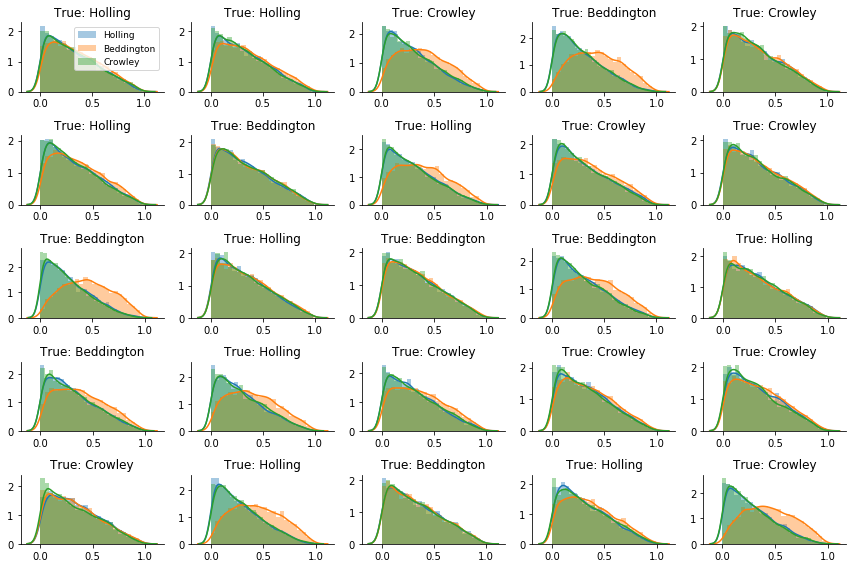

In [65]:
plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

## Manage checkpoints

In [66]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


# Train network

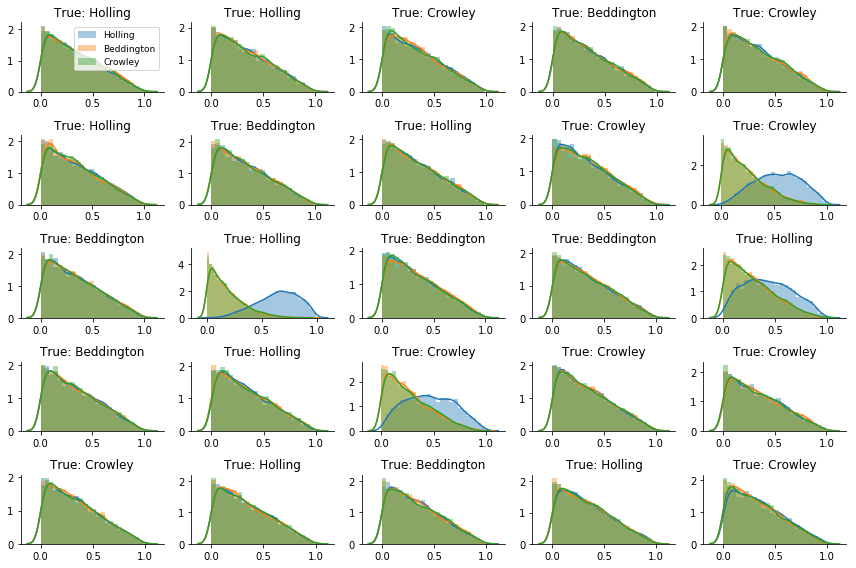

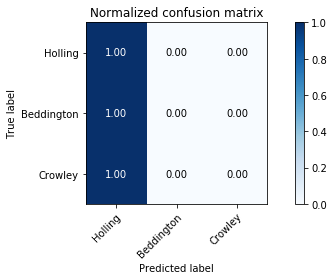

0.3566666666666667



KeyboardInterrupt: 

In [67]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=log_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence',
                              clip_method='value')
        
        # Plot stuff
        plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))
        plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, figsize=(8,4),normalize=True)
        m_pred = model(test_data['x'])['m_probs']
        print(accuracy(test_data['m'], m_pred))

        # Store checkpoint
        manager.save()

# Validate evidential network

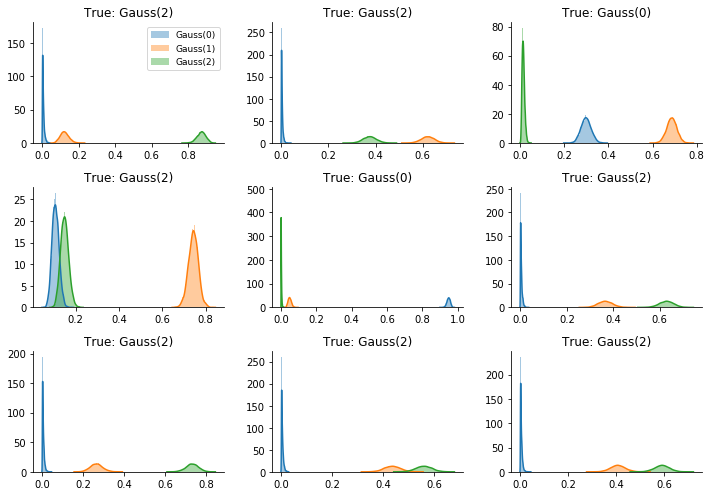

In [178]:
plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:9], 
                       m_test=test_data['m'][:9], 
                       model_names=model_names,
                       figsize=(10, 7))

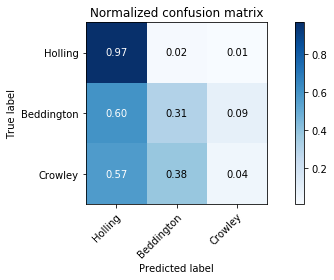

In [130]:
plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, figsize=(8,4), normalize=True)

In [148]:
m_pred = model(test_data['x'])['m_probs']
        print(accuracy(test_data['m'], m_pred))